# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pyspark 
from pyspark import SparkConf 

from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.types import StringType, LongType, IntegerType
from pyspark.sql.functions import col, sum, countDistinct, udf, max, min, isnull, datediff,desc
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoderEstimator,  StandardScaler
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import sum as Fsum

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, GBTClassifier,LinearSVC, RandomForestClassifier, DecisionTreeClassifier
from pyspark.sql.functions import avg, explode, concat, lit, min, max, split, udf, isnull, col, desc,isnan, udf, isnull,sum



import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
sparkify_event_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_event_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [4]:
df.count()

286500

In [5]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# look at individual columns.
df.describe('artist').show()

+-------+-----------------+
|summary|           artist|
+-------+-----------------+
|  count|           228108|
|   mean|551.0852017937219|
| stddev|1217.769307916138|
|    min|              !!!|
|    max|ÃÂlafur Arnalds|
+-------+-----------------+



In [8]:
 #look at individual columns.
df.describe('sessionId').show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630799|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [9]:
# look at individual columns.
df.describe('userId').show()

+-------+------------------+
|summary|            userId|
+-------+------------------+
|  count|            286500|
|   mean| 59682.02278593872|
| stddev|109091.94999910535|
|    min|                  |
|    max|                99|
+-------+------------------+



In [10]:
# Show information about the columns
df.select("artist").dropDuplicates().sort("artist").show(n=10)

+--------------------+
|              artist|
+--------------------+
|                null|
|                 !!!|
|        & And Oceans|
|'N Sync/Phil Collins|
|        'Til Tuesday|
| 't Hof Van Commerce|
|'t Hof Van Commer...|
|       (Love) Tattoo|
|          (hed) p.e.|
|*NSYNC featuring ...|
+--------------------+
only showing top 10 rows



In [11]:
# Show information about the columns

df.select("sessionId").dropDuplicates().sort("sessionId").show()

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



In [12]:
# Show information about the columns

df.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [13]:
# Show information about the columns
df.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



In [14]:
# Show information about the columns
df.select("auth").dropDuplicates().sort("auth").show()

+----------+
|      auth|
+----------+
| Cancelled|
|     Guest|
| Logged In|
|Logged Out|
+----------+



In [15]:
# Show information about the columns
df.select("gender").dropDuplicates().sort("gender").show()

+------+
|gender|
+------+
|  null|
|     F|
|     M|
+------+



In [16]:
df.select("level").dropDuplicates().sort("level").show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.


In [17]:
# Flag function
flag_cancelation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
# apply to the dataframe
df = df.withColumn("churn", flag_cancelation_event("page"))
#Define window bounds
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
# Applying the window
df = df.withColumn("churn", Fsum("churn").over(windowval))

## Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [18]:
df.dropDuplicates(['userId']).groupby(['churn']).count().show()


+-----+-----+
|churn|count|
+-----+-----+
|    0|  174|
|    1|   52|
+-----+-----+



In [19]:
# Exploring user status by gender
df.dropDuplicates(['userId', 'gender']).groupby(['churn', 'gender']).count().show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    0|     F|   84|
|    0|  null|    1|
|    1|     M|   32|
|    1|     F|   20|
|    0|     M|   89|
+-----+------+-----+



In [20]:
df.dropDuplicates(['userId', 'level']).groupby(['churn', 'level']).count().show()

+-----+-----+-----+
|churn|level|count|
+-----+-----+-----+
|    1| paid|   36|
|    1| free|   46|
|    0| free|  150|
|    0| paid|  130|
+-----+-----+-----+



Text(0.5,0,'Subscription status')

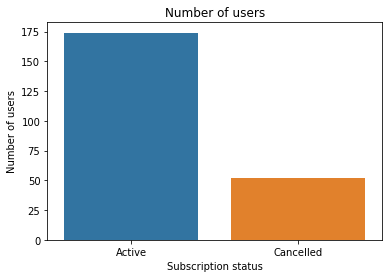

In [21]:

df_ch_pd = df.drop_duplicates(['userId']).groupby(['churn']).count().sort("churn").toPandas()
sns.barplot(data =df_ch_pd, x = 'churn',y = 'count')
churn_d = ['Active', 'Cancelled']
x_pos = np.arange(len(churn_d))
plt.xticks(x_pos,churn_d)
plt.title('Number of users')
plt.ylabel('Number of users')
plt.xlabel('Subscription status')

Text(0.5,0,'Subscription status')

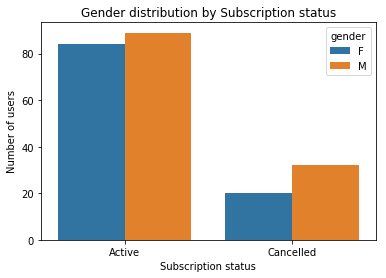

In [22]:
df_ch_pd = df.drop_duplicates(['userId', 'gender']).groupby(['churn', 'gender']).count().sort("churn").toPandas()
sns.barplot(x = 'churn', y = 'count', data = df_ch_pd, hue = 'gender')
churn_d = ['Active', 'Cancelled']
y_pos = np.arange(len(churn_d))
plt.xticks(y_pos,churn_d)
plt.title("Gender distribution by Subscription status")
plt.ylabel('Number of users')
plt.xlabel('Subscription status')

Text(0.5,0,'Level status')

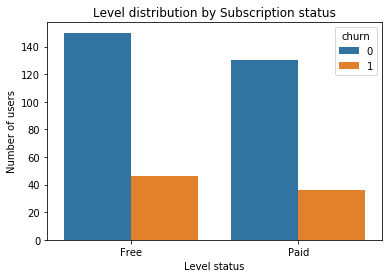

In [23]:
df_ch_pd3 = df.drop_duplicates(['userId', 'level']).groupby(['churn', 'level']).count().sort("churn").toPandas()
sns.barplot(x = 'level', y = 'count', data = df_ch_pd3, hue = 'churn')
level_d = ['Free', 'Paid']
y_pos = np.arange(len(level_d))
plt.xticks(y_pos,level_d)
plt.title("Level distribution by Subscription status")
plt.ylabel('Number of users')
plt.xlabel('Level status')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [24]:
#Number of thumbs-up
t1 = df.select('userId','page').where(df.page == 'Thumbs Up').groupBy('userId').agg({'page':'count'}).withColumnRenamed('count(page)', 'N_thumb_up')


In [25]:
# Number of thumbs-down
t2 = df .select('userId','page').where(df.page == 'Thumbs Down').groupBy('userId').agg({'page':'count'}).withColumnRenamed('count(page)', 'N_thumb_down')

In [26]:
# Gender of the user
gen= df.select('userId', 'gender').dropDuplicates().replace(['F', 'M'], ['0', '1'], 'gender').select('userId', col('gender').cast('int'))
gen.dropDuplicates(['userId']).groupby(['gender']).count().show()




+------+-----+
|gender|count|
+------+-----+
|  null|    1|
|     1|  121|
|     0|  104|
+------+-----+



In [50]:
level= df.select('userId', 'level').dropDuplicates().replace(['free', 'paid'], ['0', '1'], 'level').select('userId', col('level').cast('int'))



In [28]:
# number of  songs listened
song_l= df.select('userId', 'song').groupBy('userId').count().withColumnRenamed('count', 'total_songs')

In [29]:
# Total time spent 
length = df.select('userId','length').groupBy('userID').agg({'length':'sum'}).withColumnRenamed('sum(length)', 'listen_time')

In [30]:
# Number of lifetime
lt = df.select('userId','registration','ts').withColumn('lifetime',(df.ts-df.registration)).groupBy('userId').agg({'lifetime':'max'}).withColumnRenamed('max(lifetime)','lt')


In [31]:
# setting the churn label for our model
churn = df.select('userId', col('churn').alias('label')).dropDuplicates()

In [32]:
join_df = t1.join(t2, ['userID']) \
    .join(gen, ['userID']) \
    .join(level, ['userID']) \
    .join(song_l, ['userID']) \
    .join(length, ['userID']) \
    .join(lt, ['userID']) \
    .join(churn,['userID']) 

In [33]:
join_df.show(5)

+------+----------+------------+------+-----+-----------+------------------+-----------+-----+
|userId|N_thumb_up|N_thumb_down|gender|level|total_songs|       listen_time|         lt|label|
+------+----------+------------+------+-----+-----------+------------------+-----------+-----+
|100010|        17|           5|     0|    0|        381|       66940.89735| 4807612000|    0|
|200002|        21|           6|     1|    1|        474| 94008.87593999997| 6054448000|    0|
|200002|        21|           6|     1|    0|        474| 94008.87593999997| 6054448000|    0|
|    51|       100|          21|     1|    1|       2464| 523275.8428000001| 1680985000|    1|
|   124|       171|          41|     0|    1|       4825|1012312.0927900004|11366431000|    0|
+------+----------+------------+------+-----+-----------+------------------+-----------+-----+
only showing top 5 rows



In [36]:
# List of features 
features = ['N_thumb_up', 'N_thumb_down', 'gender', 'total_songs', 'listen_time', 'lt']
# Create ector assembler 
assembler = VectorAssembler(inputCols = features, outputCol = 'vectorized_Features')


In [37]:
join_df=assembler.transform(join_df)


In [38]:
# scale the features in the dataset 
scaler = StandardScaler(inputCol = 'vectorized_Features', outputCol = 'features')
scalerModel = scaler.fit(join_df)
join_df = scalerModel.transform(join_df)

In [39]:
data_modeling=join_df.select('label','features' )

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [40]:
train, test = data_modeling.randomSplit([0.8, 0.2], seed=0)


In [45]:
evaluator = MulticlassClassificationEvaluator(metricName = 'f1')

In [46]:
# Define the model Logistic regression
lr = LogisticRegression(maxIter=10, regParam =0.0)
paramGrid_lr = ParamGridBuilder() \
            .addGrid(lr.regParam, [0.0, 0.1]) \
            .build()
crossval= CrossValidator(estimator = lr,
                          estimatorParamMaps = paramGrid_lr,
                          evaluator = evaluator,
                          numFolds =3)
lr_model = crossval.fit(train)
lr_preds = lr_model.transform(test)
f1_score_reg_log = evaluator.evaluate(lr_preds)
print('F1-Score:',round(f1_score_reg_log,2))

F1-Score: 0.82


In [48]:
# Define the model Gradient Boosted Tree
evaluator = MulticlassClassificationEvaluator(metricName = 'f1')
gbt = GBTClassifier(maxDepth = 5, maxIter = 10, seed = 50)
paramGrid_gbt = ParamGridBuilder() \
            .addGrid(gbt.maxDepth, [5, 10]) \
            .build()
crossval_gb = CrossValidator(estimator = gbt,
                        estimatorParamMaps = paramGrid_gbt,
                        evaluator = evaluator,
                        numFolds =3)
gbt_model = crossval_gb.fit(train)
gbt_preds = gbt_model.transform(test)
# Calculate the f1-score
gbt_f1_score = evaluator.evaluate(gbt_preds)
print('F1-Score:',round(gbt_f1_score,2))

F1-Score: 0.88


In [49]:
#Define Random Forest
evaluator = MulticlassClassificationEvaluator(metricName = 'f1')
rf = RandomForestClassifier()
paramGrid_rf = ParamGridBuilder() \
            .addGrid(rf.numTrees, [20, 30]) \
            .addGrid(rf.maxDepth, [5, 10]) \
            .build()

crossval_rf = CrossValidator(estimator = rf,
                          estimatorParamMaps = paramGrid_rf,
                          evaluator = evaluator,
                          numFolds =3)
rf_model = crossval_rf.fit(train)
rf_preds = rf_model.transform(test)

# Calculate the f1-score
f1_score_forest = evaluator.evaluate(rf_preds)
print('F1-Score', round(f1_score_forest,2))


F1-Score 0.93


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.